<p style="font-family:Times New Roman, serif; font-size:18px;text-align: justify">
En este último proyecto busco obtener los posibles valores de una empresa ficticia (con ratios significativamente simples en valor y cantidad) obteniendo proyecciones aleatorias de las variables del flujo de caja con el fin de tener una idea del riesgo de invertir u obtener una empresa. A pesar de aplicar una aleatoriedad de distribución normal a través de dos modelos (GBM y ABM) a sus "inputs", sigue siendo un problema estático debido a los valores arbitrarios de las condiciones iniciales, las cuales deberían variar en cada año y ser proyectadas con una aleatoriedad inicial debido a la incertidumbre implícita en los ratios de una empresa.
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
n_simulaciones = 10000  # Número de universos a simular
n_años = 10           # Proyección a 10 años
ingresos_t0 = 500      # $500M (Ingresos año anterior)
tasa_impuestos = 0.25  # 25%
WACC = 0.09            # 9.0% (Tasa de descuento)
crecimiento_perpetuo_g = 0.03 # 3.0% (Crecimiento a perpetuidad)

# PARÁMETROS ESTOCÁSTICOS
# Driver 1: Crecimiento de Ventas
crecimiento_ventas_mu = 0.10  # Tendencia (Drift)
crecimiento_ventas_sigma = 0.08 # Incertidumbre (Volatilidad)

# Driver 2: Margen EBITDA (% de Ventas)
margen_ebitda_t0 = 0.20
margen_ebitda_mu = 0.015 # Tendencia (1.5% anual)
margen_ebitda_sigma = 0.03 # Incertidumbre de esa mejora

# Driver 3: Capex 
capex_pct_mu = 0.03    # Tendencia (5% de las ventas)
capex_pct_sigma = 0.02 # Incertidumbre

# Driver 4: Cambio en NWC (% de *Nuevas* Ventas)
nwc_pct_mu = 0.02    # Tendencia (4% de las ventas)
nwc_pct_sigma = 0.01 # Incertidumbre

print("Configuración del modelo 'TecnoCrecimiento S.A.' cargada.")

Configuración del modelo 'TecnoCrecimiento S.A.' cargada.


<p style="font-family:Times New Roman, serif; font-size:18px;text-align: justify">
Ahora están los valores iniciales definidos, con la decisión de analizar la empresa a través de su crecimiento en ventas (ingresos), Margen EBITDA, el CAPEX y la variación en el capital de trabajo operativo. 
</p>

In [3]:
caminos_crecimiento_ventas = np.zeros((n_años, n_simulaciones))
caminos_margen_ebitda = np.zeros((n_años, n_simulaciones))
caminos_capex_pct = np.zeros((n_años, n_simulaciones))
caminos_nwc_pct = np.zeros((n_años, n_simulaciones))
#  Relleno los valores iniciales (t=0) 
caminos_crecimiento_ventas[0] = crecimiento_ventas_mu
caminos_margen_ebitda[0] = margen_ebitda_t0
caminos_capex_pct[0] = capex_pct_mu
caminos_nwc_pct[0] = nwc_pct_mu


In [4]:
# Una matriz de Z aleatorio de 3 dimensiones[años, simulaciones, drivers])
shocks_aleatorios_Z = np.random.standard_normal((n_años, n_simulaciones, 4))

In [5]:
# Bucle de Proyección
for t in range(1, n_años):
    
    # 1. Crecimiento de Ventas (GBM)
    caminos_crecimiento_ventas[t] = caminos_crecimiento_ventas[t-1] * np.exp(
        (crecimiento_ventas_mu - 0.5 * crecimiento_ventas_sigma**2) + 
        crecimiento_ventas_sigma * shocks_aleatorios_Z[t, :, 0])
    
    # 2. Margen EBITDA (ABM - se mueve alrededor de la media)
    caminos_margen_ebitda[t] = caminos_margen_ebitda[t-1] + \
        (margen_ebitda_mu - caminos_margen_ebitda[t-1]) * 0.5 + \
        margen_ebitda_sigma * shocks_aleatorios_Z[t, :, 1]
    
    # 3. Capex % (ABM - se mueve alrededor de la media)
    caminos_capex_pct[t] = caminos_capex_pct[t-1] + \
        (capex_pct_mu - caminos_capex_pct[t-1]) * 0.5 + \
        capex_pct_sigma * shocks_aleatorios_Z[t, :, 2]

    # 4. NWC % (ABM)
    caminos_nwc_pct[t] = caminos_nwc_pct[t-1] + \
        (nwc_pct_mu - caminos_nwc_pct[t-1]) * 0.5 + \
        nwc_pct_sigma * shocks_aleatorios_Z[t, :, 3]

# Condicion positiva
caminos_margen_ebitda[caminos_margen_ebitda < 0] = 0.01
caminos_capex_pct[caminos_capex_pct < 0] = 0.0
caminos_nwc_pct[caminos_nwc_pct < 0] = 0.0

print("Proyección de 4 drivers para 10,000 simulaciones completada.")

Proyección de 4 drivers para 10,000 simulaciones completada.


<p style="font-family:Times New Roman, serif; font-size:18px;text-align: justify">
Se hicieron las proyecciones para cada año utilizando el algoritmo GBM (el mismo utilizado para las opciones) para el crecimiento en ventas debido a que es una tasa de crecimiento porcentual compuesto. Para los otros 3 ratios se utilizó el modelo ABM con reversión a la media por sus naturalezas oscilantes alrededor de su promedio.
</p>

In [6]:
# Arrays para guardar los resultados financieros
ventas_proyectadas = np.zeros((n_años, n_simulaciones))
ebitda_proyectado = np.zeros((n_años, n_simulaciones))
nopat_proyectado = np.zeros((n_años, n_simulaciones))
fcf_proyectado = np.zeros((n_años, n_simulaciones))

ventas_prev = ingresos_t0 # Empezar con el año base

for t in range(n_años):
    # 1. Calcular Ventas
    if t == 0:
        ventas_proyectadas[t] = ingresos_t0 * (1 + caminos_crecimiento_ventas[t])
    else:
        ventas_proyectadas[t] = ventas_proyectadas[t-1] * (1 + caminos_crecimiento_ventas[t])
    
    # 2. Calcular EBITDA
    ebitda_proyectado[t] = ventas_proyectadas[t] * caminos_margen_ebitda[t]
    
    # 3. Calcular Inversiones (Capex y NWC)
    capex = ventas_proyectadas[t] * caminos_capex_pct[t]
    
    # Delta NWC (Cambio en NWC)
    ventas_actuales = ventas_proyectadas[t]
    if t == 0:
        ventas_pasadas = ingresos_t0
    else:
        ventas_pasadas = ventas_proyectadas[t-1]
        
    delta_nwc = (ventas_actuales - ventas_pasadas) * caminos_nwc_pct[t]
    
    # 4. Calcular NOPAT (Beneficio Operativo Neto después de Impuestos)
    # Asumimos Depreciación = Capex
    depreciacion = capex 
    ebit = ebitda_proyectado[t] - depreciacion
    nopat = ebit * (1 - tasa_impuestos)
    
    # 5. Calcular FCF (Flujo de Caja Libre)
    fcf_proyectado[t] = nopat + depreciacion - capex - delta_nwc
    
print("Cálculo de 10,000 proyecciones de FCF completado.")

Cálculo de 10,000 proyecciones de FCF completado.


<p style="font-family:Times New Roman, serif; font-size:18px;text-align: justify">
Con el flujo de caja ya calculado para cada año, procedo a continuación a obtener el valor de la empresa descontando los flujos de caja futuros (debido al valor del dinero en el tiempo), es decir, trayendo a valor presente tanto el valor terminal, el cual se obtiene realizando un flujo perpetuo desde el año n+1, como el flujo de caja total para los n años. 
</p>

In [7]:
# Valor Terminal (TV) para cada simulación
fcf_ultimo_año = fcf_proyectado[-1, :] # FCF del año 10 para las 10,000 sims
valor_terminal = (fcf_ultimo_año * (1 + crecimiento_perpetuo_g)) / (WACC - crecimiento_perpetuo_g)

# Factores de descuento
factores_descuento = np.array([1 / (1 + WACC)**(t+1) for t in range(n_años)])
factores_descuento = factores_descuento.reshape(-1, 1)

# Descontar los FCF (Años 1-10)  y valor terminal (año 10)
vp_fcf_proyectados = fcf_proyectado * factores_descuento
vp_fcf_total = np.sum(vp_fcf_proyectados, axis=0) # Suma vertical (por año)
vp_valor_terminal = valor_terminal / (1 + WACC)**n_años

# Valor Total de la Empresa (Enterprise Value) 
valor_empresa_simulaciones = vp_fcf_total + vp_valor_terminal

Valor Medio (Simple - sensible a outliers): $-48.56 M
Media Recortada (Robusta - 80% central): $-55.31 M
Mediana (Valor Central - P50):            $-57.92 M
------------------------------
Intervalo de Confianza del 90%:
  5% (Peor escenario): $-752.61 M
 95% (Mejor escenario): $706.03 M


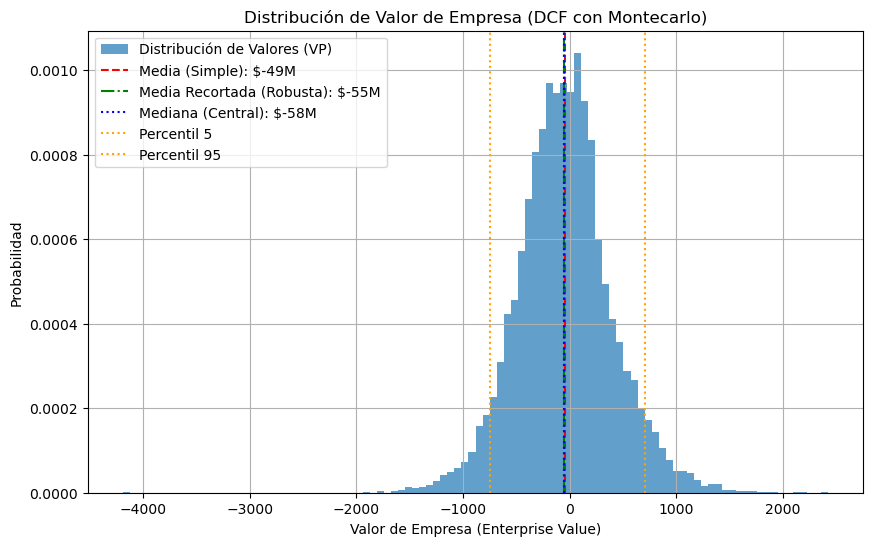

In [8]:
from scipy import stats

# Estadísticas clave
valor_medio = np.mean(valor_empresa_simulaciones)
valor_mediana = np.median(valor_empresa_simulaciones)
# Recortamos el 20% de los datos (0.1 = 10% de cada extremo)
media_recortada = stats.trim_mean(valor_empresa_simulaciones, 0.1)

# Intervalos de Confianza
percentil_5 = np.percentile(valor_empresa_simulaciones, 5)
percentil_95 = np.percentile(valor_empresa_simulaciones, 95)

print(f"Valor Medio (Simple - sensible a outliers): ${valor_medio:,.2f} M")
print(f"Media Recortada (Robusta - 80% central): ${media_recortada:,.2f} M")
print(f"Mediana (Valor Central - P50):            ${valor_mediana:,.2f} M")
print("-" * 30)
print(f"Intervalo de Confianza del 90%:")
print(f"  5% (Peor escenario): ${percentil_5:,.2f} M")
print(f" 95% (Mejor escenario): ${percentil_95:,.2f} M")


plt.figure(figsize=(10, 6))
plt.hist(valor_empresa_simulaciones, bins=100, density=True, alpha=0.7, label="Distribución de Valores (VP)")

plt.axvline(valor_medio, color='red', linestyle='--', label=f'Media (Simple): ${valor_medio:,.0f}M')
plt.axvline(media_recortada, color='green', linestyle='-.', label=f'Media Recortada (Robusta): ${media_recortada:,.0f}M')
plt.axvline(valor_mediana, color='blue', linestyle=':', label=f'Mediana (Central): ${valor_mediana:,.0f}M')

plt.axvline(percentil_5, color='orange', linestyle=':', label='Percentil 5')
plt.axvline(percentil_95, color='orange', linestyle=':', label='Percentil 95')
plt.title('Distribución de Valor de Empresa (DCF con Montecarlo)')
plt.xlabel('Valor de Empresa (Enterprise Value)')
plt.ylabel('Probabilidad')
plt.legend()
plt.grid(True)
plt.show()

<p style="font-family:Times New Roman, serif; font-size:18px;text-align: justify">
Finalmente ajuste los valores para obtener una empresa con un valor medio cercano a 0 (dentro de las escalas de los posibles valores), lo cual se puede explicar por el cercano valor de volatilidad del crecimiento de ventas a su media, por la diferencia entre el crecimiento perpetuo y el WACC, y por un margen ebitda más o menos estable en comparación con los ratios de naturaleza negativa y sus cercanos valores entre media y desviación, sin olvidar además el TAX de 0.25.
</p>
<p style="font-family:Times New Roman, serif; font-size:18px;text-align: justify">
No entro fuertemente en el análisis de esto debido a lo simple y ficticio del problema, pero busco mostrar el entendimiento de cómo se proyecta un flujo de caja junto a lo bueno que es una simulación de Monte Carlo para poder obtener rangos de valores que serían muy importantes para una posible decisión. Entiendo que la complejidad de las proyecciones y que las cantidades de ratios a utilizar son significativamente mayor a este trabajo que en principio fue pedagógico, y comprendo que dependiendo de la capacidad y métodos de análisis del lugar donde entre a trabajar, un algoritmo de este tipo tomaría una forma realista y práctica mucho más clara. 
</p>
<p style="font-family:Times New Roman, serif; font-size:18px;text-align: justify">
Considero dejar claro en este último proyecto que este es mi fuerte debido a mis estudios como Ingeniero Civil Industrial, en donde con una empresa real me sería mucho más fácil (debido a los detalles) proyectar e interpretar los distintos ratios de una empresa, aunque debido a lo aprendido también puedo comprender la estructura de una optimización y por ende ser de utilidad en esos tipos de soluciones.
</p>